# K-Nearest Neighbors on CIFAR-10

This notebook tests the KNN classifier on CIFAR-10 dataset and performs 5-fold cross-validation to find the optimal k value.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold  # type: ignore[import-untyped]
import sys
from pathlib import Path

# Add parent directory to path to import from sibling directories
sys.path.insert(0, str(Path().resolve().parent))

from knn import KNearestNeighbors
from utils import l1_distance, l2_square_distance
from dataset.cifar10 import load_cifar10, CIFAR10_CLASSES

print("Imports successful!")


Imports successful!


## Load CIFAR-10 Dataset

Load the dataset with flattened images for KNN (each image becomes a 3072-dimensional vector).

**Important:** The dataset is already split into training and test sets. We will:
1. Use the **training set** for cross-validation to select the best k
2. Hold out the **test set** completely until final evaluation
3. Never use the test set during cross-validation or hyperparameter tuning


In [ ]:
# Load CIFAR-10 data (flattened for KNN)
X_train, y_train, X_test, y_test = load_cifar10(flatten_images=True, normalize=True)

print(f"Full training set: {X_train.shape}")
print(f"Test set (held out): {X_test.shape}")
print(f"Number of classes: {len(CIFAR10_CLASSES)}")
print(f"Class names: {CIFAR10_CLASSES}")

# IMPORTANT: Split train/test BEFORE cross-validation
# The test set will be held out completely until final evaluation
# Cross-validation will only use the training set

# Use a subset of training data for faster experimentation
# (optional - increase or remove to use full dataset)
SUBSET_SIZE = 5000  # Use first 5000 training samples for CV
X_train_subset = X_train[:SUBSET_SIZE]
y_train_subset = y_train[:SUBSET_SIZE]

print(f"\nUsing {SUBSET_SIZE} training samples for cross-validation")
print(f"Test set ({X_test.shape[0]} samples) will be held out for final evaluation only")


✓ Found existing CIFAR-10 data at: C:\Users\vrpia\OneDrive\Documents\cs231n-deep-learning-for-computer-vision\dataset\cifar10\data\cifar-10-batches-py
  Using existing dataset files (no download needed).
Loaded CIFAR-10 dataset:
  Training set: 50000 images, shape (50000, 3072)
  Test set: 10000 images, shape (10000, 3072)
Training set: (50000, 3072)
Test set: (10000, 3072)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Using subset of 5000 training samples for faster experimentation


## 5-Fold Cross-Validation for k Selection

We'll test different k values using 5-fold cross-validation **on the training set only**.

The cross-validation will:
- Split the training data into 5 folds
- For each fold, train on 4 folds and validate on 1 fold
- Average the results across all folds to get a robust estimate
- **Never touch the test set** during this process


In [8]:
def cross_validate_knn(X, y, k_values, distance_func, n_folds=5, random_state=42):
    """
    Perform k-fold cross-validation to evaluate different k values.
    
    Args:
        X: Training data
        y: Training labels
        k_values: List of k values to test
        distance_func: Distance function to use
        n_folds: Number of folds for cross-validation
        random_state: Random seed for reproducibility
    
    Returns:
        Dictionary with k values as keys and (mean_accuracy, std_accuracy) as values
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    results = {}
    
    for k in k_values:
        print(f"\nTesting k={k}...")
        fold_accuracies = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"  Fold {fold_idx + 1}/{n_folds}", end="... ")
            
            # Split data
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]
            y_val_fold = y[val_idx]
            
            # Train and predict
            knn = KNearestNeighbors(distance=distance_func, k=k)
            knn.train(X_train_fold, y_train_fold)
            y_pred = knn.predict(X_val_fold)
            
            # Calculate accuracy
            accuracy = np.mean(y_pred == y_val_fold)
            fold_accuracies.append(accuracy)
            print(f"Accuracy: {accuracy:.4f}")
        
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        results[k] = (mean_accuracy, std_accuracy)
        print(f"  k={k}: Mean accuracy = {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    return results


In [11]:
# Test different k values
# Start with a small range for faster testing
k_values = [1, 3, 5, 7, 10]

print("Starting 5-fold cross-validation...")
print(f"Testing k values: {k_values}")
print(f"Using L1 distance")

# Perform cross-validation
cv_results = cross_validate_knn(
    X_train_subset, 
    y_train_subset, 
    k_values, 
    l1_distance,
    n_folds=5
)


Starting 5-fold cross-validation...
Testing k values: [1, 3, 5, 7, 10]
Using L1 distance

Testing k=1...
  Fold 1/5... Accuracy: 0.3170
  Fold 2/5... Accuracy: 0.2840
  Fold 3/5... Accuracy: 0.2850
  Fold 4/5... Accuracy: 0.2980
  Fold 5/5... Accuracy: 0.2900
  k=1: Mean accuracy = 0.2948 ± 0.0122

Testing k=3...
  Fold 1/5... Accuracy: 0.3010
  Fold 2/5... Accuracy: 0.2850
  Fold 3/5... Accuracy: 0.3000
  Fold 4/5... Accuracy: 0.2700
  Fold 5/5... Accuracy: 0.2890
  k=3: Mean accuracy = 0.2890 ± 0.0113

Testing k=5...
  Fold 1/5... Accuracy: 0.3160
  Fold 2/5... Accuracy: 0.2940
  Fold 3/5... Accuracy: 0.3130
  Fold 4/5... Accuracy: 0.2940
  Fold 5/5... Accuracy: 0.2990
  k=5: Mean accuracy = 0.3032 ± 0.0095

Testing k=7...
  Fold 1/5... Accuracy: 0.3020
  Fold 2/5... Accuracy: 0.3230
  Fold 3/5... Accuracy: 0.3200
  Fold 4/5... Accuracy: 0.2940
  Fold 5/5... Accuracy: 0.3030
  k=7: Mean accuracy = 0.3084 ± 0.0112

Testing k=10...
  Fold 1/5... Accuracy: 0.3150
  Fold 2/5... Accuracy:

## Visualize Cross-Validation Results


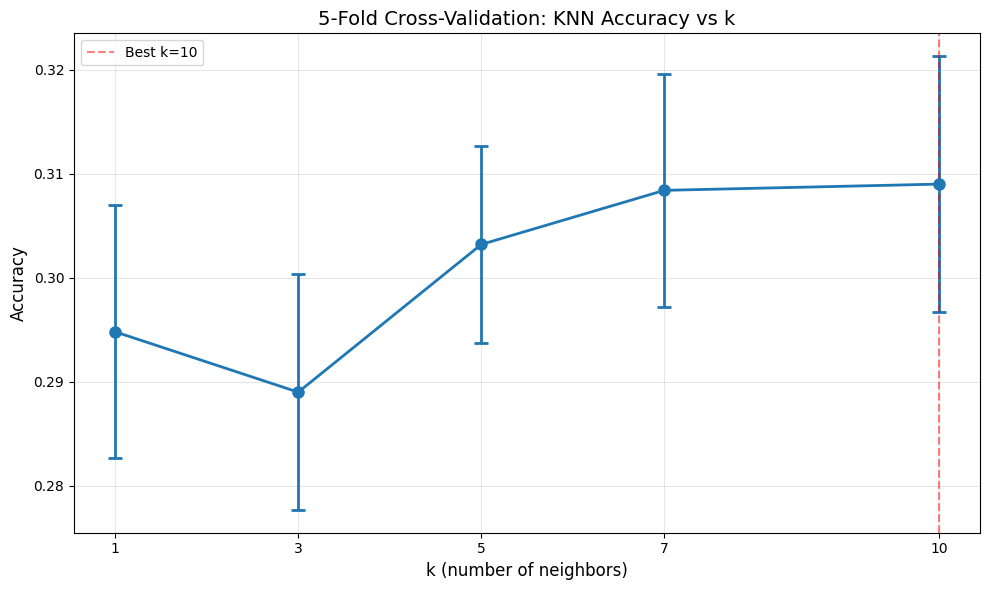


Best k: 10 with accuracy: 0.3090 ± 0.0123


In [12]:
# Extract results for plotting
k_list = list(cv_results.keys())
mean_accuracies = [cv_results[k][0] for k in k_list]
std_accuracies = [cv_results[k][1] for k in k_list]

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(k_list, mean_accuracies, yerr=std_accuracies, 
             marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
plt.xlabel('k (number of neighbors)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('5-Fold Cross-Validation: KNN Accuracy vs k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_list)

# Find best k
best_k = k_list[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies[np.argmax(mean_accuracies)]

plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Best k={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest k: {best_k} with accuracy: {best_accuracy:.4f} ± {std_accuracies[np.argmax(mean_accuracies)]:.4f}")


## Test on Full Test Set

Train on the full training subset and evaluate on the test set using the best k.


In [14]:
# Use best k from cross-validation
print(f"Training final model with k={best_k} on training subset...")
knn_final = KNearestNeighbors(distance=l2_square_distance, k=best_k)
knn_final.train(X_train_subset, y_train_subset)

# Evaluate on test set (use a subset for faster evaluation)
TEST_SUBSET_SIZE = 1000
X_test_subset = X_test[:TEST_SUBSET_SIZE]
y_test_subset = y_test[:TEST_SUBSET_SIZE]

print(f"Evaluating on {TEST_SUBSET_SIZE} test samples...")
y_pred_test = knn_final.predict(X_test_subset)
test_accuracy = np.mean(y_pred_test == y_test_subset)

print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")


Training final model with k=10 on training subset...
Evaluating on 1000 test samples...

Test Accuracy: 0.2770 (27.70%)


## Compare L1 vs L2 Distance

Compare performance of L1 (Manhattan) and L2 squared distance metrics.


Comparing L1 vs L2 squared distance with k=5...

Testing L1 distance...

Testing k=5...
  Fold 1/5... Accuracy: 0.2775
  Fold 2/5... Accuracy: 0.3000
  Fold 3/5... Accuracy: 0.2875
  Fold 4/5... Accuracy: 0.2400
  Fold 5/5... Accuracy: 0.2775
  k=5: Mean accuracy = 0.2765 ± 0.0200

Testing L2 squared distance...

Testing k=5...
  Fold 1/5... Accuracy: 0.2425
  Fold 2/5... Accuracy: 0.2550
  Fold 3/5... Accuracy: 0.2500
  Fold 4/5... Accuracy: 0.2200
  Fold 5/5... Accuracy: 0.2350
  k=5: Mean accuracy = 0.2405 ± 0.0123

Comparison (k=5):
  L1 distance:      0.2765 ± 0.0200
  L2 squared:       0.2405 ± 0.0123


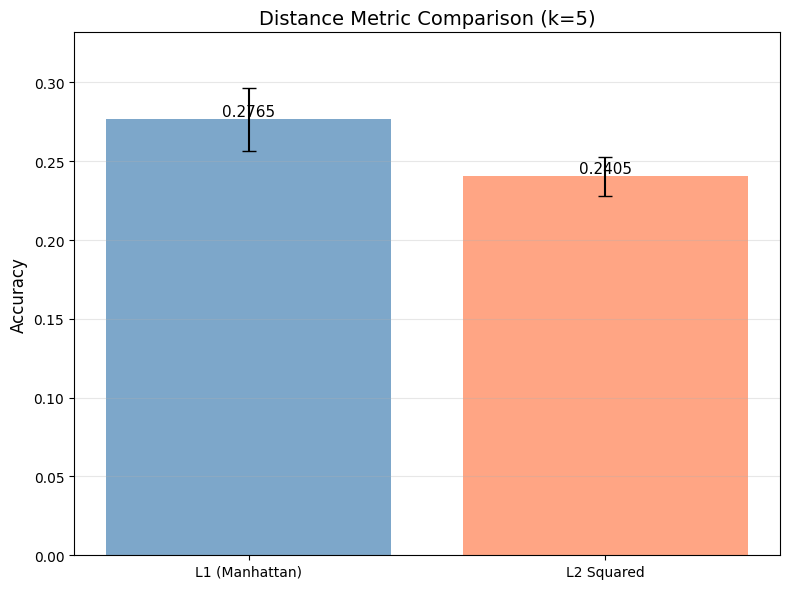

In [15]:
# Quick comparison: test both distance metrics with k=5
print("Comparing L1 vs L2 squared distance with k=5...")

# L1 distance
print("\nTesting L1 distance...")
cv_results_l1 = cross_validate_knn(
    X_train_subset[:2000],  # Use smaller subset for faster comparison
    y_train_subset[:2000],
    [5],
    l1_distance,
    n_folds=5
)

# L2 squared distance
print("\nTesting L2 squared distance...")
cv_results_l2 = cross_validate_knn(
    X_train_subset[:2000],
    y_train_subset[:2000],
    [5],
    l2_square_distance,
    n_folds=5
)

# Compare results
l1_acc = cv_results_l1[5][0]
l2_acc = cv_results_l2[5][0]

print(f"\nComparison (k=5):")
print(f"  L1 distance:      {l1_acc:.4f} ± {cv_results_l1[5][1]:.4f}")
print(f"  L2 squared:       {l2_acc:.4f} ± {cv_results_l2[5][1]:.4f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['L1 (Manhattan)', 'L2 Squared']
accuracies = [l1_acc, l2_acc]
std_errors = [cv_results_l1[5][1], cv_results_l2[5][1]]

bars = ax.bar(metrics, accuracies, yerr=std_errors, capsize=5, 
              color=['steelblue', 'coral'], alpha=0.7)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Distance Metric Comparison (k=5)', fontsize=14)
ax.set_ylim([0, max(accuracies) * 1.2])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()
